# LSTM - AQI

## Import Data

In [38]:
import pandas as pd

In [39]:
df = pd.read_csv("../data/data_imputed.csv")

In [4]:
data = df[['aqi']]

## Data PreProcessing

In [5]:
from sklearn.metrics import mean_absolute_error , mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

In [6]:
dataset = data
values = dataset.values

values = values.astype('float32')

scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [7]:
def series_to_supervised(data, n_in = 1, n_out = 1, dropnan = True):
    n_vars = 1 if type(data) is list else data.shape[1]
    
    df = pd.DataFrame(data)
    cols, names = list(), list()
    
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
        
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
            
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
        
    return agg

In [8]:
# converting the dataset as supervised learning
reframed = series_to_supervised(scaled, 168, 168)
print(reframed.shape)

(19347, 336)


In [9]:
reframed.head()

,var1(t-168),var1(t-167),var1(t-166),var1(t-165),var1(t-164),var1(t-163),var1(t-162),var1(t-161),var1(t-160),var1(t-159),...,var1(t+158),var1(t+159),var1(t+160),var1(t+161),var1(t+162),var1(t+163),var1(t+164),var1(t+165),var1(t+166),var1(t+167)
168,0.753747,0.794433,0.830835,0.839400,0.850107,0.858672,0.854390,0.850107,0.845824,0.674518,...,0.460385,0.494647,0.259101,0.284797,0.376874,0.471092,0.565310,0.659529,0.762313,0.847966
169,0.794433,0.830835,0.839400,0.850107,0.858672,0.854390,0.850107,0.845824,0.674518,0.522484,...,0.494647,0.259101,0.284797,0.376874,0.471092,0.565310,0.659529,0.762313,0.847966,0.884368
170,0.830835,0.839400,0.850107,0.858672,0.854390,0.850107,0.845824,0.674518,0.522484,0.419700,...,0.259101,0.284797,0.376874,0.471092,0.565310,0.659529,0.762313,0.847966,0.884368,0.918630
171,0.839400,0.850107,0.858672,0.854390,0.850107,0.845824,0.674518,0.522484,0.419700,0.314775,...,0.284797,0.376874,0.471092,0.565310,0.659529,0.762313,0.847966,0.884368,0.918630,0.955032
172,0.850107,0.858672,0.854390,0.850107,0.845824,0.674518,0.522484,0.419700,0.314775,0.468951,...,0.376874,0.471092,0.565310,0.659529,0.762313,0.847966,0.884368,0.918630,0.955032,0.970021


In [10]:
reframed.columns

Index(['var1(t-168)', 'var1(t-167)', 'var1(t-166)', 'var1(t-165)',
       'var1(t-164)', 'var1(t-163)', 'var1(t-162)', 'var1(t-161)',
       'var1(t-160)', 'var1(t-159)',
       ...
       'var1(t+158)', 'var1(t+159)', 'var1(t+160)', 'var1(t+161)',
       'var1(t+162)', 'var1(t+163)', 'var1(t+164)', 'var1(t+165)',
       'var1(t+166)', 'var1(t+167)'],
      dtype='object', length=336)

In [11]:
values = reframed.values

# We train the model on the 1st 3 years and then test on the last year (for now)
n_train_hours = int(365 * 24 * 1.5)

train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# reshape input to be 3D :- (no.of samples, no.of timesteps, no.of features)
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(13140, 1, 335) (13140,) (6207, 1, 335) (6207,)


## Model Fitting

### Model 1

In [12]:
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, BatchNormalization, Conv2D, ConvLSTM1D
from tensorflow.keras.models import Sequential

In [13]:
model = Sequential()
model.add(Input(shape=(train_X.shape[1], train_X.shape[2])))
model.add(LSTM(64))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 64)                  │         102,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 102,465 (400.25 KB)

 Trainable params: 102,465 (400.25 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
history = model.fit(train_X, train_y, epochs=50, batch_size=264, validation_split=0.2, verbose=2, shuffle=False)

Epoch 1/50
40/40 - 7s - 181ms/step - loss: 0.0260 - val_loss: 0.0029
Epoch 2/50
40/40 - 2s - 42ms/step - loss: 0.0078 - val_loss: 0.0031
Epoch 3/50
40/40 - 1s - 15ms/step - loss: 0.0083 - val_loss: 0.0028
Epoch 4/50
40/40 - 1s - 14ms/step - loss: 0.0090 - val_loss: 0.0029
Epoch 5/50
40/40 - 1s - 22ms/step - loss: 0.0103 - val_loss: 0.0032
Epoch 6/50
40/40 - 1s - 15ms/step - loss: 0.0136 - val_loss: 0.0020
Epoch 7/50
40/40 - 0s - 11ms/step - loss: 0.0099 - val_loss: 0.0020
Epoch 8/50
40/40 - 0s - 8ms/step - loss: 0.0057 - val_loss: 0.0019
Epoch 9/50
40/40 - 0s - 9ms/step - loss: 0.0052 - val_loss: 0.0019
Epoch 10/50
40/40 - 0s - 9ms/step - loss: 0.0055 - val_loss: 0.0019
Epoch 11/50
40/40 - 0s - 8ms/step - loss: 0.0061 - val_loss: 0.0022
Epoch 12/50
40/40 - 0s - 10ms/step - loss: 0.0076 - val_loss: 0.0025
Epoch 13/50
40/40 - 0s - 11ms/step - loss: 0.0093 - val_loss: 0.0019
Epoch 14/50
40/40 - 0s - 8ms/step - loss: 0.0070 - val_loss: 0.0018
Epoch 15/50
40/40 - 0s - 6ms/step - loss: 0.004

In [15]:
import matplotlib.pyplot as plt

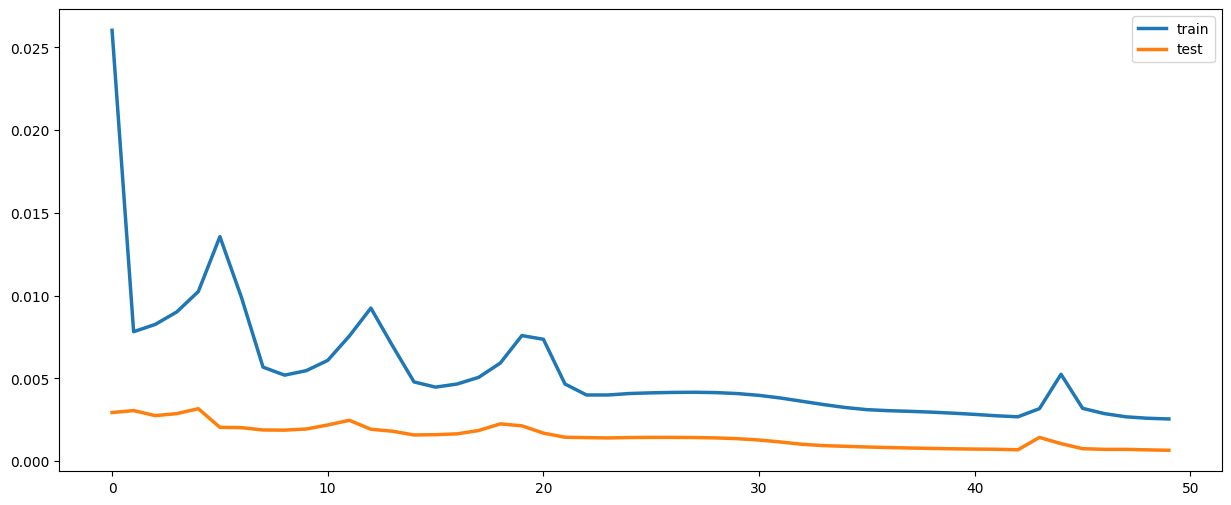

In [16]:
plt.figure(figsize=(15,6))
plt.plot(history.history['loss'], label='train', linewidth = 2.5)
plt.plot(history.history['val_loss'], label='test',  linewidth = 2.5)
plt.legend()
plt.show()

In [17]:
testPredict = model.predict(test_X)
print(testPredict.shape)
testPredict = testPredict.ravel()

print(testPredict.shape)

194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(6207, 1)
(6207,)


In [18]:
y_test_true = test[:,1]

In [19]:
import numpy as np

In [20]:
poll = np.array(df["aqi"])

meanop = poll.mean()
stdop = poll.std()

y_test_true = y_test_true*stdop + meanop
testPredict = testPredict*stdop + meanop

In [21]:
rmse = np.sqrt(mean_squared_error(test_y, testPredict))
print("Test RMSE ="  ,rmse)

Test RMSE = 167.95277


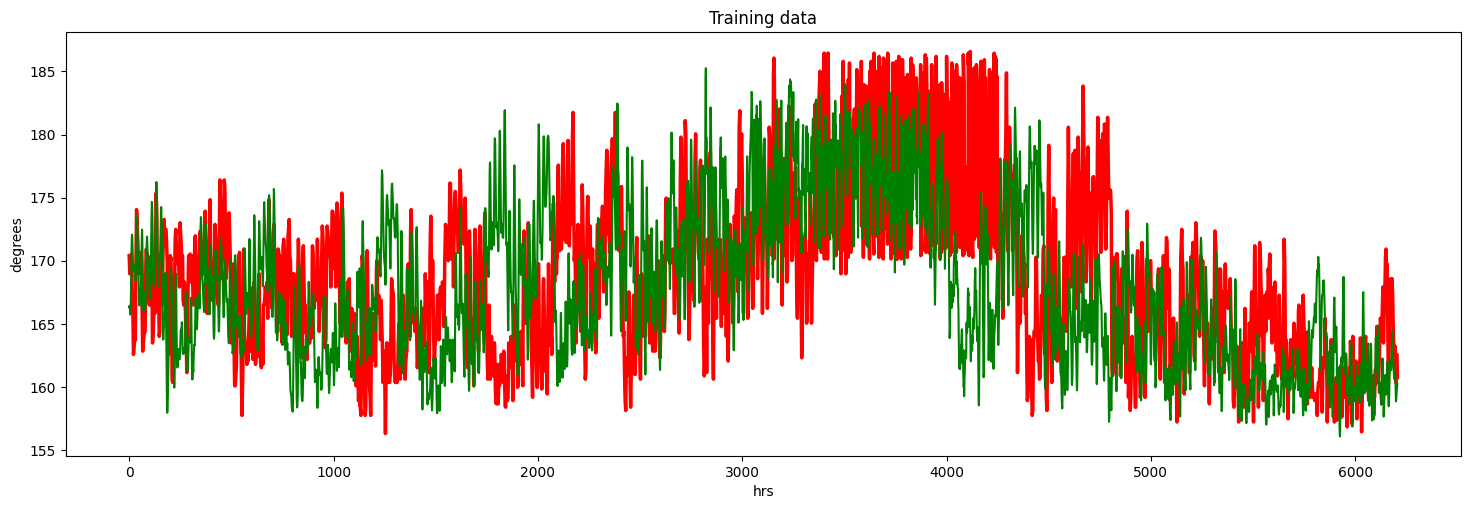

In [22]:
from matplotlib import pyplot as plt

plt.figure(figsize=(18,5.5))
plt.ylabel("degrees")
plt.xlabel("hrs")
plt.plot(y_test_true, c = "red", linewidth = 2.5)
plt.plot(testPredict, c = "green")
plt.title("Training data")
plt.show()

### Model 2

In [23]:
model2 = Sequential()
model2.add(Input(shape=(train_X.shape[1], train_X.shape[2])))
model2.add(LSTM(256))
model2.add(Dense(64))
model2.add(Dropout(0.25))
model2.add(BatchNormalization())
model2.add(Dense(1))

model2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                        │ (None, 256)                 │         606,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 622,977 (2.38 MB)

 Trainable params: 622,849 (2.38 MB)

 Non-trainable params: 128 (512.00 B)

In [24]:
model2.compile(loss='mse', optimizer='adam')

hist2 = model2.fit(train_X, train_y, epochs=50, batch_size=128, validation_data=(test_X, test_y))

Epoch 1/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 1.2791 - val_loss: 0.0304
Epoch 2/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.3540 - val_loss: 0.0361
Epoch 3/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.1264 - val_loss: 0.0256
Epoch 4/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0271 - val_loss: 0.0161
Epoch 5/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0113 - val_loss: 0.0090
Epoch 6/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0077 - val_loss: 0.0064
Epoch 7/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0063 - val_loss: 0.0017
Epoch 8/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0053 - val_loss: 0.0012
Epoch 9/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0045 - val_loss: 0.0011
Epoch 10/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0043 - val_loss: 0.0011
Epoch 11/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0040 - val_loss: 0.0023
Epoch 12/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 

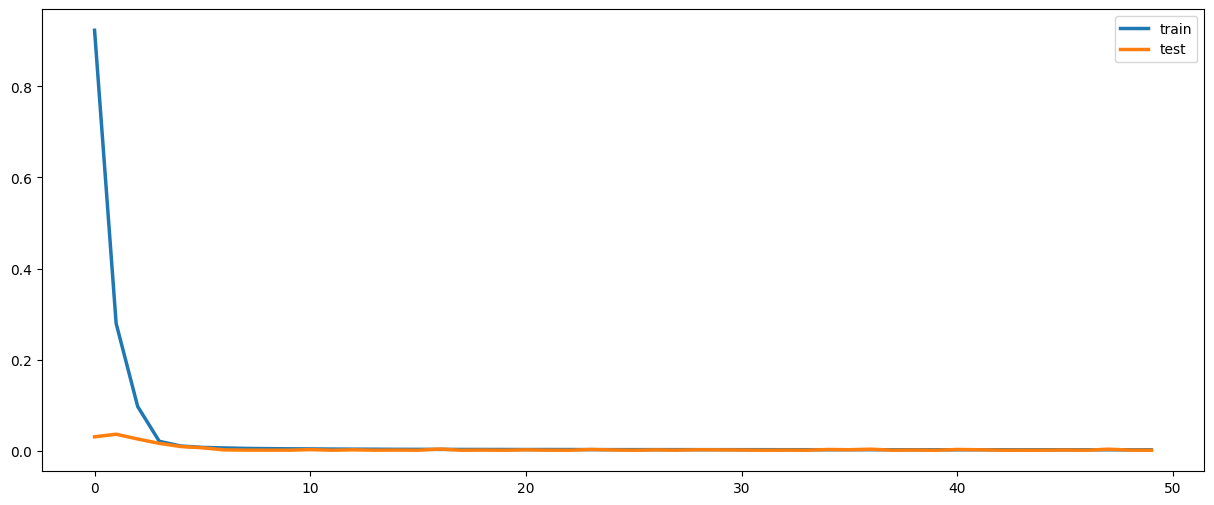

In [25]:
plt.figure(figsize=(15,6))
plt.plot(hist2.history['loss'], label='train', linewidth = 2.5)
plt.plot(hist2.history['val_loss'], label='test',  linewidth = 2.5)
plt.legend()
plt.show()

In [26]:
y_test_true = test[:,1]

In [27]:
testPredict2 = model2.predict(test_X)
testPredict2 = testPredict2.ravel()

# Inverse scaling the output, for better visual interpretation 

poll = np.array(df["aqi"])
meanop = poll.mean()
stdop = poll.std()

print(meanop, stdop)

y_test_true = y_test_true*stdop + meanop
testPredict2 = testPredict2*stdop + meanop

194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
154.76323544355247 60.89766406961439


In [28]:
rmse = np.sqrt(mean_squared_error(y_test_true, testPredict2))
print("Test(Validation) RMSE ="  ,rmse)

Test(Validation) RMSE = 7.0438437


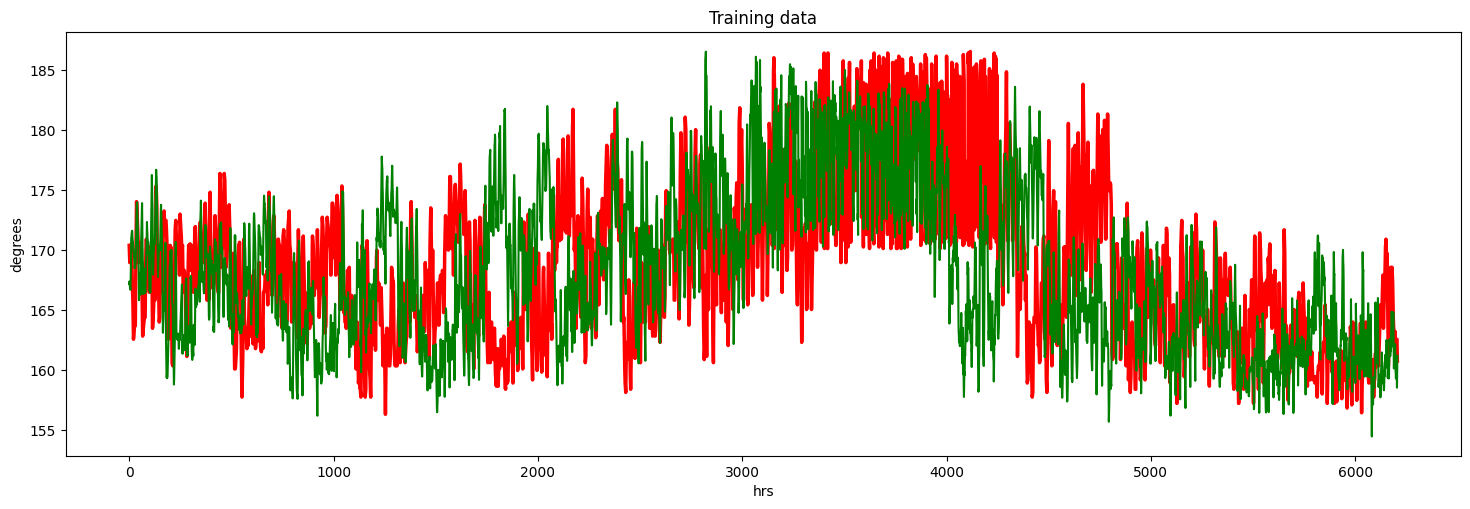

In [29]:
from matplotlib import pyplot as plt

plt.figure(figsize=(18,5.5))
plt.ylabel("degrees")
plt.xlabel("hrs")
plt.plot(y_test_true, c = "red", linewidth = 2.5)
plt.plot(testPredict2, c = "green")
plt.title("Training data")
plt.show()

### Model 3

In [30]:
model3 = Sequential()
model3.add(Input(shape=(train_X.shape[1], train_X.shape[2])))
model3.add(LSTM(256))
model3.add(Dense(32))
model3.add(Dropout(0.25))
model3.add(BatchNormalization())
model3.add(Dense(1))
model3.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 256)                 │         606,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 32)                  │           8,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 614,593 (2.34 MB)

 Trainable params: 614,529 (2.34 MB)

 Non-trainable params: 64 (256.00 B)

In [31]:
model3.compile(loss='mse', optimizer='adam')

hist3 = model3.fit(train_X, train_y, epochs=50, batch_size=256, validation_split=0.2)

Epoch 1/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.9083 - val_loss: 0.0088
Epoch 2/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.4842 - val_loss: 0.0753
Epoch 3/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.2299 - val_loss: 0.0753
Epoch 4/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.1694 - val_loss: 0.0762
Epoch 5/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.1293 - val_loss: 0.0388
Epoch 6/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.1058 - val_loss: 0.0475
Epoch 7/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0841 - val_loss: 0.0302
Epoch 8/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0683 - val_loss: 0.0119
Epoch 9/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0541 - val_loss: 0.0120
Epoch 10/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0523 - val_loss: 0.0065
Epoch 11/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0419 - val_loss: 0.0027
Epoch 12/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0

In [32]:
y_test_true = test[:,1]

In [33]:
testPredict3 = model3.predict(test_X)
testPredict3 = testPredict3.ravel()

# Inverse scaling the output, for better visual interpretation 

poll = np.array(df["aqi"])
meanop = poll.mean()
stdop = poll.std()

print(meanop, stdop)

y_test_true = y_test_true*stdop + meanop
testPredict3 = testPredict3*stdop + meanop

194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
154.76323544355247 60.89766406961439


In [34]:
rmse = np.sqrt(mean_squared_error(y_test_true, testPredict3))
print("Training RMSE ="  ,rmse)

Training RMSE = 6.7874646


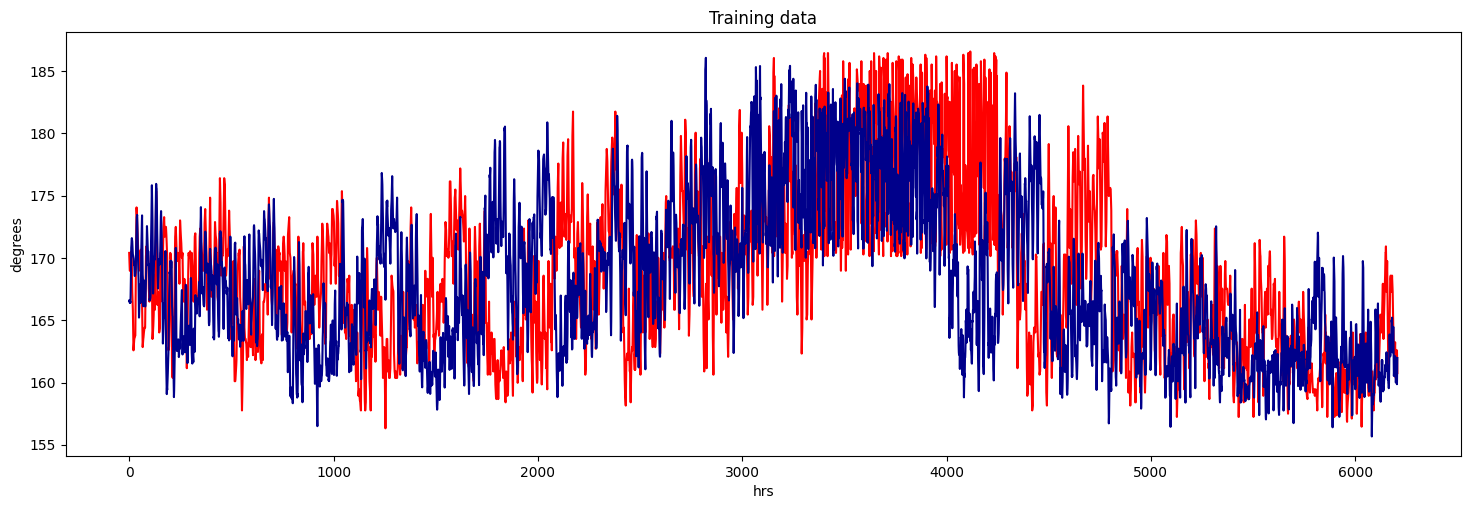

In [35]:
from matplotlib import pyplot as plt

plt.figure(figsize=(18,5.5))
# plt.xlim([1000,1250])
plt.ylabel("degrees")
plt.xlabel("hrs")
plt.plot(y_test_true, c = "red")
plt.plot(testPredict3, c = "darkblue")
plt.title("Training data")
plt.show()

## Forecast

In [37]:
# Assuming you have `model` already trained and `meanop` and `stdop` calculated

# Initialize an array to store forecasted values
forecast_values = []

# Use the last available data point from your dataset as the initial input
last_input = test_X[-1]

# Define the number of time steps you want to forecast
num_steps = 168  # Adjust according to your needs

for _ in range(num_steps):
    # Reshape input data for prediction
    input_data = np.expand_dims(last_input, axis=0)

    # Make prediction
    forecast = model.predict(input_data)

    # Inverse transform forecasted value
    forecast = forecast.ravel() * stdop + meanop

    # Store forecasted value
    forecast_values.append(forecast)

    # Update input data for the next time step by shifting and appending forecasted value
    last_input = np.roll(last_input, -1)
    last_input[-1] = (forecast - meanop) / stdop  # Normalize the forecasted value

# Convert forecast_values to a numpy array
forecast_values = np.array(forecast_values)

# Print or use forecast_values for further analysis
print(forecast_values)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━

In [40]:
# Assuming you have `model` already trained and `meanop` and `stdop` calculated

# Initialize an array to store forecasted values
forecast_values = []

# Use the last available data point from your dataset as the initial input
last_input = test_X[-1]

# Define the number of time steps you want to forecast
num_steps = 7  # Adjust according to your needs

for _ in range(num_steps):
    # Reshape input data for prediction
    input_data = np.expand_dims(last_input, axis=0)

    # Make prediction
    forecast = model2.predict(input_data)

    # Inverse transform forecasted value
    forecast = forecast.ravel() * stdop + meanop

    # Store forecasted value
    forecast_values.append(forecast)

    # Update input data for the next time step by shifting and appending forecasted value
    last_input = np.roll(last_input, -1)
    last_input[-1] = (forecast - meanop) / stdop  # Normalize the forecasted value

# Convert forecast_values to a numpy array
forecast_values = np.array(forecast_values)

# Print or use forecast_values for further analysis
print(forecast_values)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
[[26.589716]
 [26.703257]
 [26.812525]
 [26.917513]
 [27.018232]
 [27.114712]
 [27.207   ]]


In [41]:
# Assuming you have `model` already trained and `meanop` and `stdop` calculated

# Initialize an array to store forecasted values
forecast_values = []

# Use the last available data point from your dataset as the initial input
last_input = test_X[-1]

# Define the number of time steps you want to forecast
num_steps = 7  # Adjust according to your needs

for _ in range(num_steps):
    # Reshape input data for prediction
    input_data = np.expand_dims(last_input, axis=0)

    # Make prediction
    forecast = model3.predict(input_data)

    # Inverse transform forecasted value
    forecast = forecast.ravel() * stdop + meanop

    # Store forecasted value
    forecast_values.append(forecast)

    # Update input data for the next time step by shifting and appending forecasted value
    last_input = np.roll(last_input, -1)
    last_input[-1] = (forecast - meanop) / stdop  # Normalize the forecasted value

# Convert forecast_values to a numpy array
forecast_values = np.array(forecast_values)

# Print or use forecast_values for further analysis
print(forecast_values)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
[[26.40213 ]
 [26.336603]
 [26.275059]
 [26.21723 ]
 [26.162868]
 [26.111746]
 [26.063652]]


In [40]:
# Prepare the data for the LSTM model
def create_dataset(data, time_step=1, forecast_horizon=1):
    X, y = [], []
    for i in range(len(data) - time_step - forecast_horizon):
        X.append(data[i:(i + time_step)])
        y.append(data[(i + time_step):(i + time_step + forecast_horizon)])
    return np.array(X), np.array(y)

In [41]:
df.head()

,timestamp_local,temp,city_name,country_code,aqi,co,no2,o3,pm10,pm25,so2
0,01/02/2022 0:00,12.6,Gujrāt,PK,385,1339.8,76.0,10.7,491.7,347.67,238.0
1,01/02/2022 1:00,11.5,Gujrāt,PK,404,1437.6,76.0,9.3,508.3,359.33,268.0
2,01/02/2022 2:00,11.9,Gujrāt,PK,421,1535.5,76.0,8.0,525.0,371.00,298.0
3,01/02/2022 3:00,12.2,Gujrāt,PK,425,1659.0,68.3,5.3,529.3,374.00,275.7
4,01/02/2022 4:00,11.9,Gujrāt,PK,430,1782.5,60.7,2.7,533.7,377.00,253.3


In [43]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df[['aqi']])

In [44]:
# Create dataset with a lookback of 24 hours and a forecast horizon of 12 hours
time_step = 168
forecast_horizon = 168
X, y = create_dataset(scaled_data, time_step, forecast_horizon)

In [45]:
# Split the data into training and testing sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [46]:
# Reshape the input data to be 3D [samples, time_steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [67]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
# Build the LSTM model
# model = Sequential()
# model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
# model.add(LSTM(50, return_sequences=False))



model = Sequential()
model.add(Input(shape=(time_step, 1)))
# model.add(LSTM(8, return_sequences=True))
model.add(LSTM(500))
model.add(Dense(32*forecast_horizon))
# model.add(Dropout(0.25))
# model.add(BatchNormalization())
# model.add(Dropout(0.2))
model.add(Dense(forecast_horizon))

In [68]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

# Train the model
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train, validation_split=0.2, epochs=10, batch_size=32, callbacks=[early_stop])

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_9 (LSTM)                        │ (None, 500)                 │       1,004,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 5376)                │       2,693,376 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 168)                 │         903,336 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,600,712 (17.55 MB)

 Trainable params: 4,600,712 (17.55 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
387/387 ━━━━━━━━━━━━━━━━━━━━ 453s 1s/step - loss: 0.0544 - val_loss: 0.0059
Epoch 2/10
387/387 ━━━━━━━━━━━━━━━━━━━━ 431s 1s/step - loss: 0.0103 - val_loss: 0.0051
Epoch 3/10
240/387 ━━━━━━━━━━━━━━━━━━━━ 2:57 1s/step - loss: 0.0098

KeyboardInterrupt: 

In [ ]:
# Predict on the test data
predicted = model.predict(X_test)

In [63]:
y_test_reshaped = y_test.reshape((y_test.shape[0] * y_test.shape[1], 1))  # Reshape to 2D array
y_test_inverse = scaler.inverse_transform(y_test_reshaped)
y_test_inverse = y_test_inverse.reshape(y_test.shape)  # Reshape back to original shape

In [64]:
# Flatten the arrays for RMSE calculation
y_test_flat = y_test_inverse.flatten()
predicted_flat = predicted.flatten()

In [65]:
rmse = np.sqrt(mean_squared_error(y_test_flat, predicted_flat))

In [66]:
rmse

156.09619536406592